# Import Libray

In [74]:
import pandas as pd
import numpy as np
from numba import jit
from math import log, floor

# Load ASD Single Data

In [75]:
content = pd.read_csv('EEG Data/ASD/EEG_Data_ASD_1.csv')
content 

,Time,STATUS,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,Unnamed: 10
0,5.640,12582912,2077229,-1107,-777316,-8388608,-1151,2735523,7730810,8100856,NaN
1,5.644,12582912,2077792,-1111,-779661,-8388608,-1152,2736304,7723511,8100944,NaN
2,5.648,12582912,2078484,-1104,-782021,-8388608,-1159,2737063,7722882,8100980,NaN
3,5.652,12582912,2079233,-1097,-784418,-8388608,-1152,2736442,7726571,8100881,NaN
4,5.656,12582912,2079923,-1107,-786942,-8388608,-1144,2735071,7735209,8100812,NaN
...,...,...,...,...,...,...,...,...,...,...,...
25842,109.008,12582912,4703740,-1109,-6080171,-8388608,-1141,282140,7448751,7815234,NaN
25843,109.012,12582912,4704349,-1107,-6079897,-8388608,-1151,284472,7452863,7817067,NaN
25844,109.016,12582912,4704951,-1102,-6079683,-8388608,-1157,286293,7456491,7818378,NaN
25845,109.020,12582912,4705506,-1109,-6079704,-8388608,-1148,288444,7460394,7819983,NaN


In [76]:
content.isnull().sum()

Time               0
STATUS             0
CH1                0
CH2                0
CH3                0
CH4                0
CH5                0
CH6                0
CH7                0
CH8                0
Unnamed: 10    25847
dtype: int64

In [77]:
# Remove Unnecessary Column (1,2,last)
content=content.iloc[:, 2:]
content=content.iloc[:, :-1]
content

,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8
0,2077229,-1107,-777316,-8388608,-1151,2735523,7730810,8100856
1,2077792,-1111,-779661,-8388608,-1152,2736304,7723511,8100944
2,2078484,-1104,-782021,-8388608,-1159,2737063,7722882,8100980
3,2079233,-1097,-784418,-8388608,-1152,2736442,7726571,8100881
4,2079923,-1107,-786942,-8388608,-1144,2735071,7735209,8100812
...,...,...,...,...,...,...,...,...
25842,4703740,-1109,-6080171,-8388608,-1141,282140,7448751,7815234
25843,4704349,-1107,-6079897,-8388608,-1151,284472,7452863,7817067
25844,4704951,-1102,-6079683,-8388608,-1157,286293,7456491,7818378
25845,4705506,-1109,-6079704,-8388608,-1148,288444,7460394,7819983


In [78]:
# take first column i.e. CH2 channel
x = content.iloc[ : , 1 : 2 ].values
x = x.flatten()
x

array([-1107, -1111, -1104, ..., -1102, -1109, -1103], dtype=int64)

# Linear Regression Function

In [79]:
def _linear_regression(x, y):
    # Ensure inputs are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    
    n_times = x.size
    
    # Compute sums using numpy functions for efficiency
    sx2 = np.sum(x ** 2)
    sx = np.sum(x)
    sy = np.sum(y)
    sxy = np.sum(x * y)
    
    # Compute the denominator and numerator for the slope
    den = n_times * sx2 - sx ** 2
    num = n_times * sxy - sx * sy
    
    if den == 0:
        raise ValueError("Denominator in slope calculation is zero, cannot compute slope.")
    
    # Calculate the slope
    slope = num / den
    
    # Calculate the intercept
    intercept = np.mean(y) - slope * np.mean(x)
    
    return slope, intercept

# Higuchi’s Fractal Dimension (HFD)

In [80]:
def _higuchi_fd(x, kmax):
    n_times = x.size
    # print("Kmax:", kmax)
    # print("n_times:", n_times)
    
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    
    for k in range(1, kmax + 1):
        # print("k:", k)
        lm = np.zeros(k)
        
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            # print("  m:", m, "n_max:", n_max)
            
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            
            ll /= k
            if n_max > 0:
                ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
            # print("  lm[{}]: {}".format(m, lm[m]))
        
        m_lm = np.mean(lm)
        # print('  Mean lm:', m_lm)
        
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm) if m_lm > 0 else 0
        # print("  log(1/k):", x_reg[k - 1], "log(m_lm):", y_reg[k - 1])
    
    # print("x_reg:", x_reg)
    # print("y_reg:", y_reg)
    
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi

# Higuchi_FD Processing

In [81]:
import numpy as np
def higuchi_fd(x, kmax):
   x = np.asarray(x, dtype=np.float64)
   kmax = int(kmax)
   return _higuchi_fd(x, kmax)

In [82]:
# ASD signle column HFD value
print('HFD value:',higuchi_fd(x, kmax=2))  # find channel CH2's HFD value for 2 k_max

HFD value: 1.6467808633809993


# Load Control Single Data

In [83]:
content2 = pd.read_csv('EEG Data/Control/EEG_Data_Control_1.csv')
content2 

,Time,STATUS,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,Unnamed: 10
0,9.312,12582912,-2687,-2256,-163,-7466,-7147,-8114,-6556,-9976,NaN
1,9.316,12582912,-9994,-3216,-7564,-22084,-22064,-24431,-20778,-5776,NaN
2,9.320,12582912,-3673,350,-4924,-5358,-5840,-6399,-5556,9530,NaN
3,9.324,12582912,7706,3211,4571,19481,19035,21041,18035,12171,NaN
4,9.328,12582912,8745,2274,7725,17913,18105,19910,17158,153,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20945,93.092,12582912,15928,32767,5923,-32768,-32768,-32768,-32768,-32768,NaN
20946,93.096,12582912,-7681,32767,-1513,-28807,-18977,-31769,-31017,-17150,NaN
20947,93.100,12582912,-14351,32767,-5213,32767,32767,32767,32767,32767,NaN
20948,93.104,12582912,-1368,32767,676,32767,32767,32767,32767,32767,NaN


In [84]:
# Remove Unnecessary Column (1,2,last)
content2=content2.iloc[:, 2:]
content2=content2.iloc[:, :-1]
content2

,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8
0,-2687,-2256,-163,-7466,-7147,-8114,-6556,-9976
1,-9994,-3216,-7564,-22084,-22064,-24431,-20778,-5776
2,-3673,350,-4924,-5358,-5840,-6399,-5556,9530
3,7706,3211,4571,19481,19035,21041,18035,12171
4,8745,2274,7725,17913,18105,19910,17158,153
...,...,...,...,...,...,...,...,...
20945,15928,32767,5923,-32768,-32768,-32768,-32768,-32768
20946,-7681,32767,-1513,-28807,-18977,-31769,-31017,-17150
20947,-14351,32767,-5213,32767,32767,32767,32767,32767
20948,-1368,32767,676,32767,32767,32767,32767,32767


In [85]:
# take first column i.e. CH2 channel
x = content2.iloc[ : , 1 : 2 ].values
x = x.flatten()
x

array([-2256, -3216,   350, ..., 32767, 32767, 32767], dtype=int64)

In [86]:
# Control signle column HFD value
print('HFD value:',higuchi_fd(x, kmax=2))

HFD value: 1.2989696003728115


# HFD for all ASD Patients

In [87]:
#find HFD for all patients for different k_max value where k_max in range (2,256)
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
files = glob.glob("EEG Data/ASD/*.csv")
dfa_ASD = pd.DataFrame()
print(files)

for f in files:
    csv = pd.read_csv(f)
    csv = csv.iloc[:, 2:-1]
    #print("For cse file:",csv)
    
    # # Normalize each CSV file
    scaler = MinMaxScaler()
    csv_normalized = pd.DataFrame(scaler.fit_transform(csv), columns=csv.columns)
    # # print(csv_normalized)
    
    hfd = []
    for i in range(0, 8):
        x = csv_normalized.iloc[:, i:i+1].values
        x = x.flatten()
        print("\nColumn Array:",x)
        hdf = higuchi_fd(x, kmax=2)
        print('HFD value:',hdf)
        hfd.append(hdf)
    
    print("Single file hfd value:",hfd)
    print("\n")
    df = pd.DataFrame(hfd).T
    dfa_ASD = pd.concat([dfa_ASD, df])

['EEG Data/ASD\\EEG_Data_ASD_1.csv', 'EEG Data/ASD\\EEG_Data_ASD_2.csv', 'EEG Data/ASD\\EEG_Data_ASD_3.csv', 'EEG Data/ASD\\EEG_Data_ASD_4.csv', 'EEG Data/ASD\\EEG_Data_ASD_5.csv', 'EEG Data/ASD\\EEG_Data_ASD_6.csv', 'EEG Data/ASD\\EEG_Data_ASD_7.csv']

Column Array: [0.00000000e+00 2.04958764e-04 4.56879661e-04 ... 9.56615727e-01
 9.56817773e-01 9.57001981e-01]
HFD value: 1.0188743271612013

Column Array: [0.48 0.4  0.54 ... 0.58 0.44 0.56]
HFD value: 1.6467808633807257

Column Array: [1.         0.99959567 0.99918875 ... 0.08575245 0.08574883 0.08578831]
HFD value: 1.308661585846798

Column Array: [0. 0. 0. ... 0. 0. 0.]
HFD value: 0.0

Column Array: [0.42 0.4  0.26 ... 0.3  0.48 0.46]
HFD value: 1.6460138111263014

Column Array: [0.99959928 0.9998025  1.         ... 0.36229728 0.36285698 0.36358972]
HFD value: 1.1598326025785124

Column Array: [0.99727242 0.99425687 0.99399701 ... 0.88393896 0.88555146 0.88741144]
HFD value: 1.293189344975593

Column Array: [0.9999519  0.99998603 1.

# HFD for all ASD Patients in One Files

In [88]:
dp_ASD = dfa_ASD.rename(columns={0: "HFD_CH1", 1: "HFD_CH2",2: "HFD_CH3", 3: "HFD_CH4",4: "HFD_CH5", 5: "HFD_CH6",6: "HFD_CH7", 7: "HFD_CH8"})
dp_ASD.to_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv',index =  False)
dp_ASD

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8
0,1.018874,1.646781,1.308662,0.000000,1.646014,1.159833,1.293189,1.085149
0,1.292728,1.282449,1.298007,1.218142,1.219392,1.225938,1.355062,1.241649
0,1.007617,1.001238,1.001041,1.042725,0.000000,1.016467,1.184509,1.000074
0,1.295538,1.313719,1.894082,1.304783,1.292827,1.284088,1.285472,1.206340
0,1.272842,1.233262,1.199123,1.298080,1.293972,1.294362,1.463775,1.329732
0,1.150327,1.272775,1.215841,1.111145,1.171914,1.167852,1.179476,1.133429
0,1.423927,2.158058,2.637469,1.723207,1.654371,1.544446,1.592501,2.613783


# Min/Max/Avg/Std value from HFD_ASD file

In [89]:
# Min/Max/Avg/Std value from HFD_ASD file
import glob
files = glob.glob("EEG Data/ASD/HFD_ASD/*.csv")
mean1 = []
min1 = []
max1 = []
std1 = []
for f in files:
    csv = pd.read_csv(f)
    print(f)
    x = csv.iloc[ : , :].values
    mean1.append(x.mean())
    max1.append(x.max())
    min1.append(x.min())
    std1.append(x.std())
    print('Average hfd of ASD:', x.mean())
    print('Minimum hfd of ASD:', x.min())
    print('Maximum hfd of ASD:', x.max())
    print('Standard deviation of hfd of ASD:', x.std())

EEG Data/ASD/HFD_ASD\HFD_ASD_10.csv
Average hfd of ASD: 1.4997727990359901
Minimum hfd of ASD: 0.0
Maximum hfd of ASD: 2.2677800707616567
Standard deviation of hfd of ASD: 0.44411044377508685
EEG Data/ASD/HFD_ASD\HFD_ASD_100.csv
Average hfd of ASD: 1.1679863350532098
Minimum hfd of ASD: -1.2481655517975363
Maximum hfd of ASD: 2.015940240078669
Standard deviation of hfd of ASD: 0.9214560480044861
EEG Data/ASD/HFD_ASD\HFD_ASD_128.csv
Average hfd of ASD: 1.1738150294402867
Minimum hfd of ASD: -1.3529518823580302
Maximum hfd of ASD: 2.0187755820625264
Standard deviation of hfd of ASD: 0.9706866767341741
EEG Data/ASD/HFD_ASD\HFD_ASD_160.csv
Average hfd of ASD: 1.193540500691114
Minimum hfd of ASD: -1.3479040474276394
Maximum hfd of ASD: 2.022472591682289
Standard deviation of hfd of ASD: 0.9886734260077393
EEG Data/ASD/HFD_ASD\HFD_ASD_2.csv
Average hfd of ASD: 1.2956796166928128
Minimum hfd of ASD: 0.0
Maximum hfd of ASD: 2.6374685241966964
Standard deviation of hfd of ASD: 0.41333737665262

# HFD for all Control Human

In [90]:
#find HFD for all Control Human for different k_max value where k_max in range (2,256)
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
files = glob.glob("EEG Data/Control/*.csv")
dfa_Control = pd.DataFrame()
print(files)

for f in files:
    csv = pd.read_csv(f)
    csv = csv.iloc[:, 2:-1]
    #print("For cse file:",csv)
    
    # # Normalize each CSV file
    scaler = MinMaxScaler()
    csv_normalized = pd.DataFrame(scaler.fit_transform(csv), columns=csv.columns)
    # # print(csv_normalized)
    
    hfd = []
    for i in range(0, 8):
        x = csv_normalized.iloc[:, i:i+1].values
        x = x.flatten()
        print("\nColumn Array:",x)
        hdf = higuchi_fd(x, kmax=2)
        print('HFD value:',hdf)
        hfd.append(hdf)
    
    print("Single file hfd value:",hfd)
    print("\n")
    df = pd.DataFrame(hfd).T
    dfa_Control = pd.concat([dfa_Control, df])

['EEG Data/Control\\EEG_Data_Control_1.csv', 'EEG Data/Control\\EEG_Data_Control_2.csv', 'EEG Data/Control\\EEG_Data_Control_3.csv', 'EEG Data/Control\\EEG_Data_Control_4.csv', 'EEG Data/Control\\EEG_Data_Control_5.csv', 'EEG Data/Control\\EEG_Data_Control_6.csv', 'EEG Data/Control\\EEG_Data_Control_7.csv', 'EEG Data/Control\\EEG_Data_Control_8.csv', 'EEG Data/Control\\EEG_Data_Control_9.csv']

Column Array: [0.4513633  0.32315682 0.43406323 ... 0.24671018 0.47450609 0.64768221]
HFD value: 1.3136400106184634

Column Array: [0.46558328 0.45093462 0.50534829 ... 1.         1.         1.        ]
HFD value: 1.2989696003728115

Column Array: [0.49752041 0.38458839 0.42487221 ... 0.42046235 0.51032273 0.6010071 ]
HFD value: 1.3270211902468207

Column Array: [0.38608377 0.16302739 0.41824979 ... 1.         1.         0.51445792]
HFD value: 1.1155767136142434

Column Array: [0.3909514  0.16333257 0.41089494 ... 1.         1.         0.4708629 ]
HFD value: 1.123153861279412

Column Array: [0.3

# HFD for all Control Patient in One Files

In [91]:
# HFD for all Control Patient in One Files
dp_Control = dfa_Control.rename(columns={0: "HFD_CH1", 1: "HFD_CH2",2: "HFD_CH3", 3: "HFD_CH4",4: "HFD_CH5", 5: "HFD_CH6",6: "HFD_CH7", 7: "HFD_CH8"})
dp_Control.to_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv',index =  False)
dp_Control

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8
0,1.313640,1.298970,1.327021,1.115577,1.123154,1.094726,1.124519,1.127621
0,1.331508,1.328215,1.333186,1.197387,1.251806,1.207185,1.230873,1.244407
0,1.188641,1.354464,1.257411,1.294776,1.096950,1.264200,1.194478,1.185693
0,1.318128,1.318086,1.292205,1.316812,1.313917,1.318854,1.317213,1.186054
0,1.127311,1.297023,1.469743,1.212986,1.375303,1.466550,1.313403,1.846541
0,1.127311,1.297023,1.469743,1.212986,1.375303,1.466550,1.313403,0.000000
0,1.112420,1.039227,1.055550,1.049690,1.020937,1.076666,1.009106,1.017519
0,1.057159,1.056820,1.132209,1.022172,1.011533,1.016073,1.008883,1.013018
0,1.160189,1.151932,1.315195,1.223468,1.314294,1.300377,1.175902,1.272155


# Min/Max/Avg/Std value from HFD_Control file

In [92]:
# Min/Max/Avg/Std value from HFD_Control file
import glob
files = glob.glob("EEG Data/Control/HFD_Control/*.csv")
mean1 = []
min1 = []
max1 = []
std1 = []
for f in files:
    csv = pd.read_csv(f)
    print(f)
    x = csv.iloc[ : , :].values
    mean1.append(x.mean())
    max1.append(x.max())
    min1.append(x.min())
    std1.append(x.std())
    print('Average hfd of Control:', x.mean())
    print('Minimum hfd of Control:', x.min())
    print('Maximum hfd of Control:', x.max())
    print('Standard deviation of hfd of Control:', x.std())

EEG Data/Control/HFD_Control\HFD_Control_10.csv
Average hfd of Control: 1.6454410949903329
Minimum hfd of Control: 0.0
Maximum hfd of Control: 2.526873240080535
Standard deviation of hfd of Control: 0.5461509563282323
EEG Data/Control/HFD_Control\HFD_Control_100.csv
Average hfd of Control: 1.113922889685333
Minimum hfd of Control: -0.938243448625025
Maximum hfd of Control: 1.9878413073517447
Standard deviation of hfd of Control: 0.9926378122723095
EEG Data/Control/HFD_Control\HFD_Control_128.csv
Average hfd of Control: 1.0631992995149686
Minimum hfd of Control: -1.1635386253934883
Maximum hfd of Control: 2.005712827758966
Standard deviation of hfd of Control: 1.1233550917883521
EEG Data/Control/HFD_Control\HFD_Control_160.csv
Average hfd of Control: 1.0524235305745646
Minimum hfd of Control: -1.2878029234104946
Maximum hfd of Control: 1.996885288206062
Standard deviation of hfd of Control: 1.1821761012833423
EEG Data/Control/HFD_Control\HFD_Control_2.csv
Average hfd of Control: 1.20626

In [93]:
!pip install shap


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Another Necessary Libraries

In [94]:
#Import Another Necessary Libraries
import numpy as np
import pandas as pd
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

# Combine One CSV file from HFD of ASD and Control with all Patient

In [95]:
# Cobine One CSV file from HFD of ASD and Control with all Patient
import os
import pandas as pd

# Path to the EEG Data folder
eeg_data_path = "EEG Data"

# Initialize an empty list to store DataFrames
dfs = []

# Loop through ASD and Control folders
for folder in ["ASD", "Control"]:
    folder_path = os.path.join(eeg_data_path, folder, "HFD_" + folder)
    
    # Loop through files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            
            # Read CSV file into DataFrame
            df = pd.read_csv(file_path)
            
            # Add a new column "Class" to identify ASD (1) or Control (0)
            df["Class"] = 1 if folder == "ASD" else 0
            
            # Append DataFrame to the list
            dfs.append(df)

# Concatenate DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame as "HFD_ASD_Control.csv" in the "EEG Data" folder
combined_file_path = os.path.join(eeg_data_path, "HFD_ASD_Control.csv")
combined_df.to_csv(combined_file_path, index=False)

print("Combined file saved as:", combined_file_path)


Combined file saved as: EEG Data\HFD_ASD_Control.csv


# Print Combine HFD of ASD and Control  

In [96]:
dfa=pd.read_csv('EEG Data/HFD_ASD_Control.csv')
dfa

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8,Class
0,1.020497,1.917996,1.349071,0.000000,1.923019,1.216372,1.748945,1.069162,1
1,1.706968,1.625886,1.827281,1.393598,1.438352,1.400129,1.723234,1.455506,1
2,1.010099,1.002608,1.001369,1.061762,0.000000,1.028190,1.254981,1.000309,1
3,1.843649,2.267780,2.021265,2.038527,1.907534,1.772715,1.832807,1.389427,1
4,1.486485,1.510619,1.383923,1.852370,1.806557,1.818844,1.997518,1.534451,1
...,...,...,...,...,...,...,...,...,...
155,1.031630,1.298082,1.206036,1.262295,1.109554,1.013371,1.269579,0.248653,0
156,1.031630,1.298082,1.206036,1.262295,1.109554,1.013371,1.269579,0.000000,0
157,1.045466,1.014359,1.037253,1.012867,1.022402,1.029425,1.018031,1.012945,0
158,1.036322,1.020239,1.227959,1.078080,1.101483,1.107782,1.053650,1.063549,0


In [97]:
X = dfa.iloc[:,0:8].values
y = dfa.iloc[:,8:].values
print(X.shape)
print(y)

(160, 8)
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


# XGBRegressor Define

In [98]:
xgb = XGBRegressor(n_estimators=10)
xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [99]:
xgb.feature_importances_

array([0.10097734, 0.21781956, 0.08497113, 0.03274347, 0.10979553,
       0.1663461 , 0.15561292, 0.13173395], dtype=float32)

In [100]:
feature_names = ['HFD_CH1',	'HFD_CH2',	'HFD_CH3', 'HFD_CH4',	'HFD_CH5',	'HFD_CH6',	'HFD_CH7',	'HFD_CH8']
feature_names = np.array(feature_names)

<BarContainer object of 8 artists>

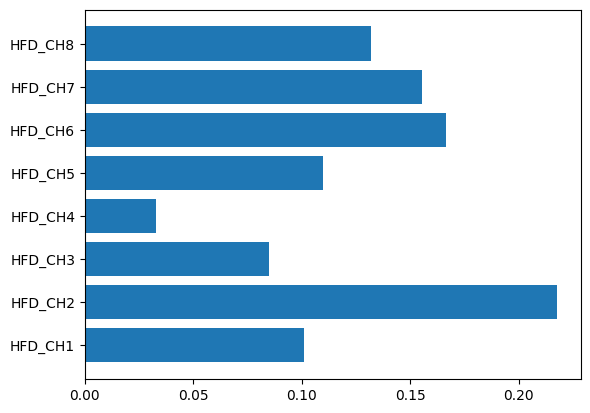

In [101]:
plt.barh(feature_names, xgb.feature_importances_)

# Xgboost Feature Importance

In [102]:
xgb = XGBRegressor(n_estimators=10)
xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Xgboost Feature Importance')

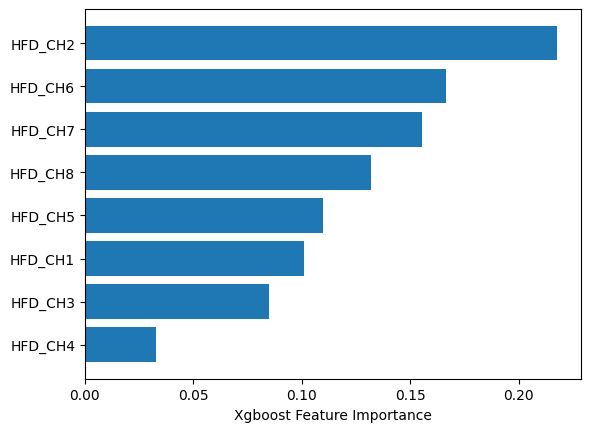

In [103]:
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(feature_names[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

# Correlation Heatmap

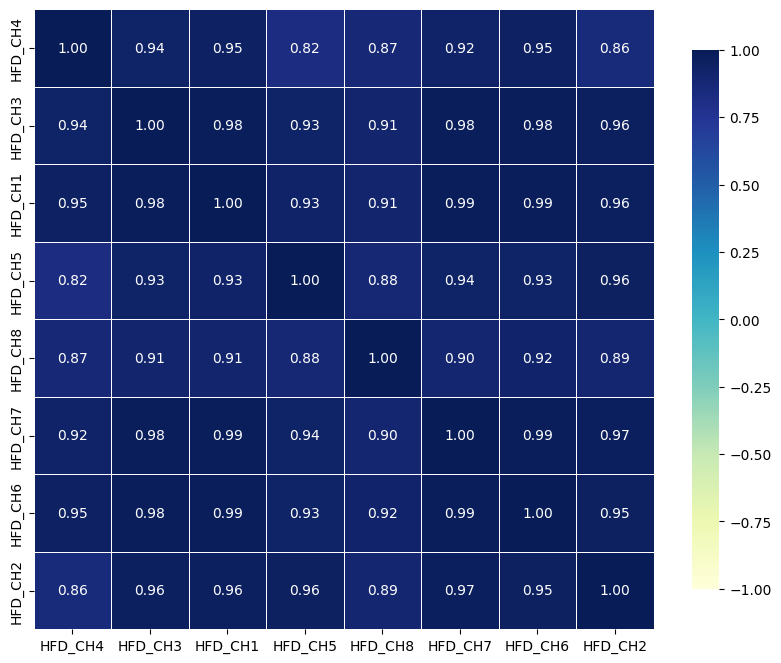

In [104]:
def correlation_heatmap(train):
    correlations = train.corr()

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create the heatmap with a new color scheme
    sns.heatmap(
        correlations,
        vmax=1.0,
        vmin=-1.0,
        center=0,
        fmt='.2f',
        cmap="YlGnBu",  # Changing to a green-blue color palette
        square=True,
        linewidths=.5,
        annot=True,
        cbar_kws={"shrink": .70}
    )
    
    # Show the plot
    plt.show()

# Example usage with a DataFrame `dfa` and a list of feature names
# Ensure that `dfa` and `feature_names` are defined
correlation_heatmap(dfa[feature_names[sorted_idx]])

# Min/Max/Avg/Std value Without Channel Reduction from HFD_ASD file

In [105]:
# Min/Max/Avg/Std value Without Channel Reduction from HFD_ASD file
dfa = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv') 
x = dfa.iloc[ : , :].values
print('Average hfd of ASD without channel reduction:', x.mean())
print('Minimum hfd of ASD without channel reduction:', x.min())
print('Maximum hfd of ASD without channel reduction:', x.max())
print('Standard deviation of hfd of ASD without channel reduction:', x.std())

Average hfd of ASD without channel reduction: 1.2956796166928128
Minimum hfd of ASD without channel reduction: 0.0
Maximum hfd of ASD without channel reduction: 2.6374685241966964
Standard deviation of hfd of ASD without channel reduction: 0.4133373766526275


# Min/Max/Avg/Std value Without Channel Reduction from HFD_Control file

In [106]:
# Min/Max/Avg/Std value without Channel Reduction from HFD_Control file
dfa = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv') 
x = dfa.iloc[ : , :].values
print('Average hfd of Control without channel reduction:', x.mean())
print('Minimum hfd of Control without channel reduction:', x.min())
print('Maximum hfd of Control without channel reduction:', x.max())
print('Standard deviation of hfd of Control without channel reduction:', x.std())

Average hfd of Control without channel reduction: 1.206268732366063
Minimum hfd of Control without channel reduction: 0.0
Maximum hfd of Control without channel reduction: 1.846541192232209
Standard deviation of hfd of Control without channel reduction: 0.20384066568049222


# Some Channel count for Reduction

In [107]:
#Some Channel count for Reduction
cols = ['HFD_CH2','HFD_CH5','HFD_CH6','HFD_CH7','HFD_CH8']

# Min/Max/Avg/Std value after Channel Reduction from HFD_ASD file

In [108]:
# Min/Max/Avg/Std value after Channel Reduction from HFD_ASD file
dfa = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv') 
dfa = dfa[cols]
#print(dfa)
x = dfa.iloc[ : , :].values
print('Average hfd of ASD after channel reduction:', x.mean())
print('Minimum hfd of ASD after channel reduction:', x.min())
print('Maximum hfd of ASD after channel reduction:', x.max())
print('Standard deviation of hfd of ASD after channel reduction:', x.std())

Average hfd of ASD after channel reduction: 1.309825643650379
Minimum hfd of ASD after channel reduction: 0.0
Maximum hfd of ASD after channel reduction: 2.6137833153850587
Standard deviation of hfd of ASD after channel reduction: 0.3830663874083182


# Min/Max/Avg/Std value after Channel Reduction from HFD_Control file

In [109]:
# Min/Max/Avg/Std value after Channel Reduction from HFD_Control file
dfa = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv') 
dfa = dfa[cols]
#print(dfa)
x = dfa.iloc[ : , :].values
print('Average hfd of Control after channel reduction:', x.mean())
print('Minimum hfd of Control after channel reduction:', x.min())
print('Maximum hfd of Control after channel reduction:', x.max())
print('Standard deviation of hfd of Control after channel reduction:', x.std())

Average hfd of Control after channel reduction: 1.1959317250981931
Minimum hfd of Control after channel reduction: 0.0
Maximum hfd of Control after channel reduction: 1.846541192232209
Standard deviation of hfd of Control after channel reduction: 0.24011337427820975


# Distribution of HFD Values Without Channel Reduction

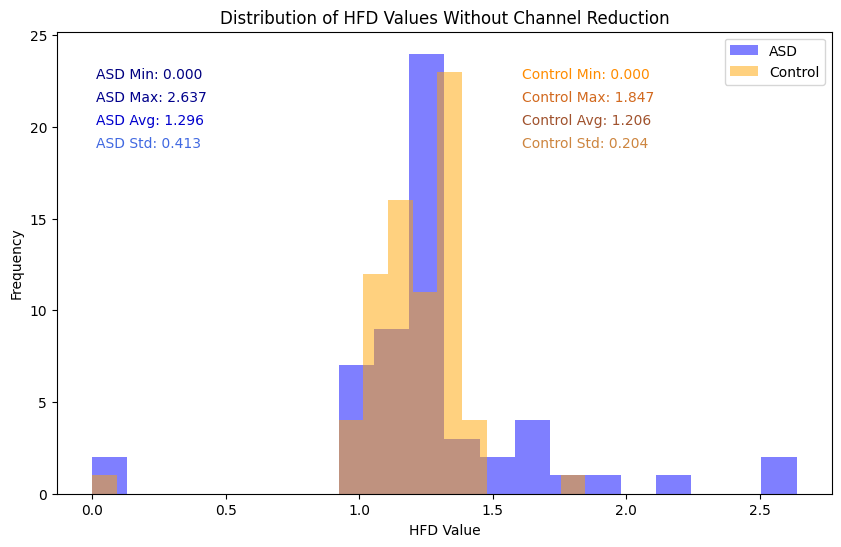

In [110]:
# Distribution of HFD Values Without Channel Reduction
import pandas as pd
import matplotlib.pyplot as plt

# Read ASD and Control data
asd_df = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv')
control_df = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv')

all_values = asd_df.values.flatten()
# Calculate statistics for ASD group
asd_min = all_values.min()
asd_max = all_values.max()
asd_std = all_values.std()
asd_avg = all_values.mean()

all_values = control_df.values.flatten()
# Calculate statistics for Control group
control_min = all_values.min()
control_max = all_values.max()
control_std = all_values.std()
control_avg = all_values.mean()

# Plot histograms
plt.figure(figsize=(10, 6))

# Histograms for ASD and Control
plt.hist(asd_df.values.flatten(), bins=20, alpha=0.5, color='blue', label='ASD')
plt.hist(control_df.values.flatten(), bins=20, alpha=0.5, color='orange', label='Control')

# Text annotations for ASD
plt.text(0.05, 0.9, f"ASD Min: {asd_min:.3f}", transform=plt.gca().transAxes, color='navy')
plt.text(0.05, 0.85, f"ASD Max: {asd_max:.3f}", transform=plt.gca().transAxes, color='darkblue')
plt.text(0.05, 0.8, f"ASD Avg: {asd_avg:.3f}", transform=plt.gca().transAxes, color='mediumblue')
plt.text(0.05, 0.75, f"ASD Std: {asd_std:.3f}", transform=plt.gca().transAxes, color='royalblue')

# Text annotations for Control
plt.text(0.6, 0.9, f"Control Min: {control_min:.3f}", transform=plt.gca().transAxes, color='darkorange')
plt.text(0.6, 0.85, f"Control Max: {control_max:.3f}", transform=plt.gca().transAxes, color='chocolate')
plt.text(0.6, 0.8, f"Control Avg: {control_avg:.3f}", transform=plt.gca().transAxes, color='sienna')
plt.text(0.6, 0.75, f"Control Std: {control_std:.3f}", transform=plt.gca().transAxes, color='peru')

plt.title('Distribution of HFD Values Without Channel Reduction')
plt.xlabel('HFD Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()


# Distribution of HFD Values After Channel Reduction

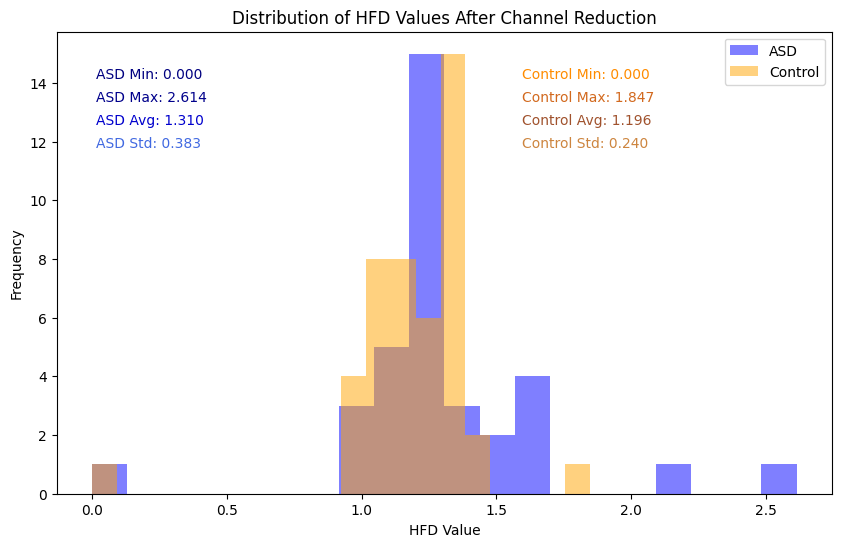

In [111]:
#Distribution of HFD Values After Channel Reduction
import pandas as pd
import matplotlib.pyplot as plt

# Read ASD and Control data
asd_df = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv')[cols]
control_df = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv')[cols]

all_values = asd_df.values.flatten()
# Calculate statistics for ASD group
asd_min = all_values.min()
asd_max = all_values.max()
asd_std = all_values.std()
asd_avg = all_values.mean()

all_values = control_df.values.flatten()
# Calculate statistics for Control group
control_min = all_values.min()
control_max = all_values.max()
control_std = all_values.std()
control_avg = all_values.mean()

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(asd_df.values.flatten(), bins=20, alpha=0.5, color='blue', label='ASD')
plt.hist(control_df.values.flatten(), bins=20, alpha=0.5, color='orange', label='Control')

# Text annotations for ASD
plt.text(0.05, 0.9, f"ASD Min: {asd_min:.3f}", transform=plt.gca().transAxes, color='navy')
plt.text(0.05, 0.85, f"ASD Max: {asd_max:.3f}", transform=plt.gca().transAxes, color='darkblue')
plt.text(0.05, 0.8, f"ASD Avg: {asd_avg:.3f}", transform=plt.gca().transAxes, color='mediumblue')
plt.text(0.05, 0.75, f"ASD Std: {asd_std:.3f}", transform=plt.gca().transAxes, color='royalblue')

# Text annotations for Control
plt.text(0.6, 0.9, f"Control Min: {control_min:.3f}", transform=plt.gca().transAxes, color='darkorange')
plt.text(0.6, 0.85, f"Control Max: {control_max:.3f}", transform=plt.gca().transAxes, color='chocolate')
plt.text(0.6, 0.8, f"Control Avg: {control_avg:.3f}", transform=plt.gca().transAxes, color='sienna')
plt.text(0.6, 0.75, f"Control Std: {control_std:.3f}", transform=plt.gca().transAxes, color='peru')

plt.title('Distribution of HFD Values After Channel Reduction')
plt.xlabel('HFD Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

# Distribution of HFD Values Before and After Channel Reduction

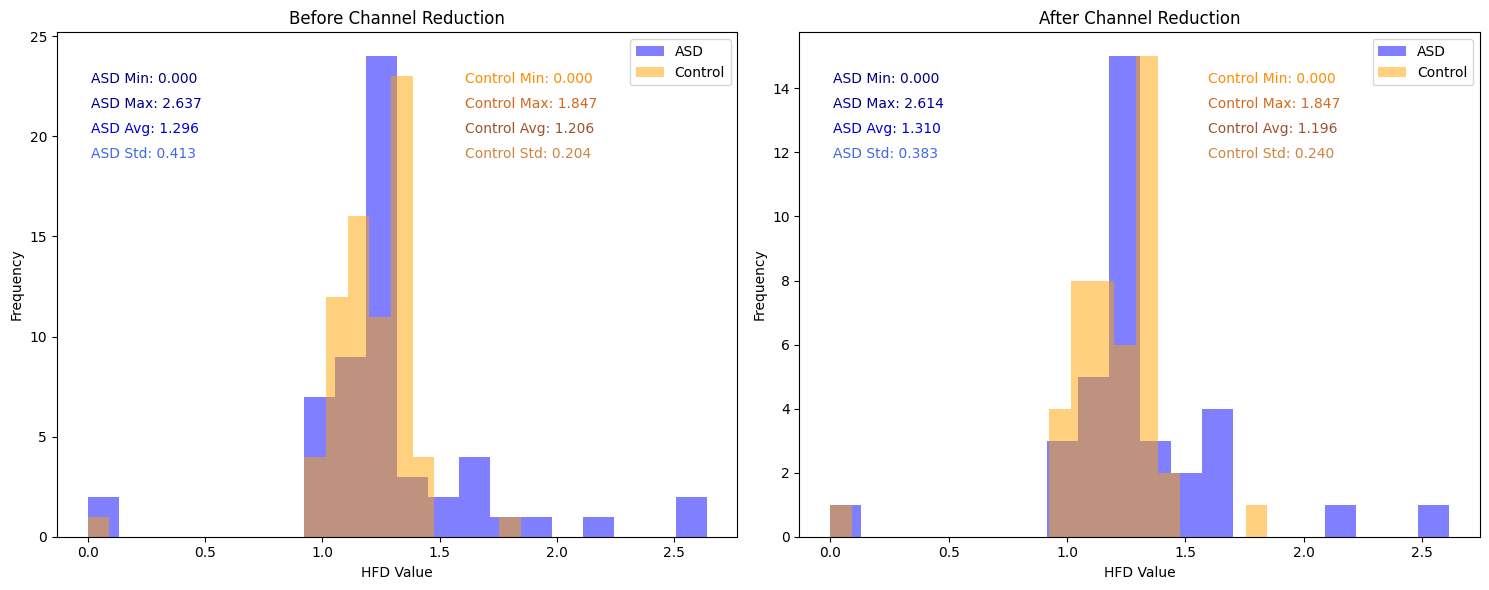

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# Read ASD and Control data without channel reduction
asd_df_before = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv')
control_df_before = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv')

# Read ASD and Control data after channel reduction
asd_df_after = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv')[cols]
control_df_after = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv')[cols]

# Calculate statistics for both groups without channel reduction
asd_min_before = asd_df_before.values.min()
asd_max_before = asd_df_before.values.max()
asd_std_before = asd_df_before.values.std()
asd_avg_before = asd_df_before.values.mean()

control_min_before = control_df_before.values.min()
control_max_before = control_df_before.values.max()
control_std_before = control_df_before.values.std()
control_avg_before = control_df_before.values.mean()

# Calculate statistics for both groups after channel reduction
asd_min_after = asd_df_after.values.min()
asd_max_after = asd_df_after.values.max()
asd_std_after = asd_df_after.values.std()
asd_avg_after = asd_df_after.values.mean()

control_min_after = control_df_after.values.min()
control_max_after = control_df_after.values.max()
control_std_after = control_df_after.values.std()
control_avg_after = control_df_after.values.mean()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histograms for before channel reduction
axes[0].hist(asd_df_before.values.flatten(), bins=20, alpha=0.5, color='blue', label='ASD')
axes[0].hist(control_df_before.values.flatten(), bins=20, alpha=0.5, color='orange', label='Control')

# Text annotations for before channel reduction
axes[0].text(0.05, 0.9, f"ASD Min: {asd_min_before:.3f}", transform=axes[0].transAxes, color='navy')
axes[0].text(0.05, 0.85, f"ASD Max: {asd_max_before:.3f}", transform=axes[0].transAxes, color='darkblue')
axes[0].text(0.05, 0.8, f"ASD Avg: {asd_avg_before:.3f}", transform=axes[0].transAxes, color='mediumblue')
axes[0].text(0.05, 0.75, f"ASD Std: {asd_std_before:.3f}", transform=axes[0].transAxes, color='royalblue')

axes[0].text(0.6, 0.9, f"Control Min: {control_min_before:.3f}", transform=axes[0].transAxes, color='darkorange')
axes[0].text(0.6, 0.85, f"Control Max: {control_max_before:.3f}", transform=axes[0].transAxes, color='chocolate')
axes[0].text(0.6, 0.8, f"Control Avg: {control_avg_before:.3f}", transform=axes[0].transAxes, color='sienna')
axes[0].text(0.6, 0.75, f"Control Std: {control_std_before:.3f}", transform=axes[0].transAxes, color='peru')

axes[0].set_title('Before Channel Reduction')
axes[0].set_xlabel('HFD Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot histograms for after channel reduction
axes[1].hist(asd_df_after.values.flatten(), bins=20, alpha=0.5, color='blue', label='ASD')
axes[1].hist(control_df_after.values.flatten(), bins=20, alpha=0.5, color='orange', label='Control')

# Text annotations for after channel reduction
axes[1].text(0.05, 0.9, f"ASD Min: {asd_min_after:.3f}", transform=axes[1].transAxes, color='navy')
axes[1].text(0.05, 0.85, f"ASD Max: {asd_max_after:.3f}", transform=axes[1].transAxes, color='darkblue')
axes[1].text(0.05, 0.8, f"ASD Avg: {asd_avg_after:.3f}", transform=axes[1].transAxes, color='mediumblue')
axes[1].text(0.05, 0.75, f"ASD Std: {asd_std_after:.3f}", transform=axes[1].transAxes, color='royalblue')

axes[1].text(0.6, 0.9, f"Control Min: {control_min_after:.3f}", transform=axes[1].transAxes, color='darkorange')
axes[1].text(0.6, 0.85, f"Control Max: {control_max_after:.3f}", transform=axes[1].transAxes, color='chocolate')
axes[1].text(0.6, 0.8, f"Control Avg: {control_avg_after:.3f}", transform=axes[1].transAxes, color='sienna')
axes[1].text(0.6, 0.75, f"Control Std: {control_std_after:.3f}", transform=axes[1].transAxes, color='peru')

axes[1].set_title('After Channel Reduction')
axes[1].set_xlabel('HFD Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

# Distribution of HFD Values Before and After Channel Reduction in One Figure

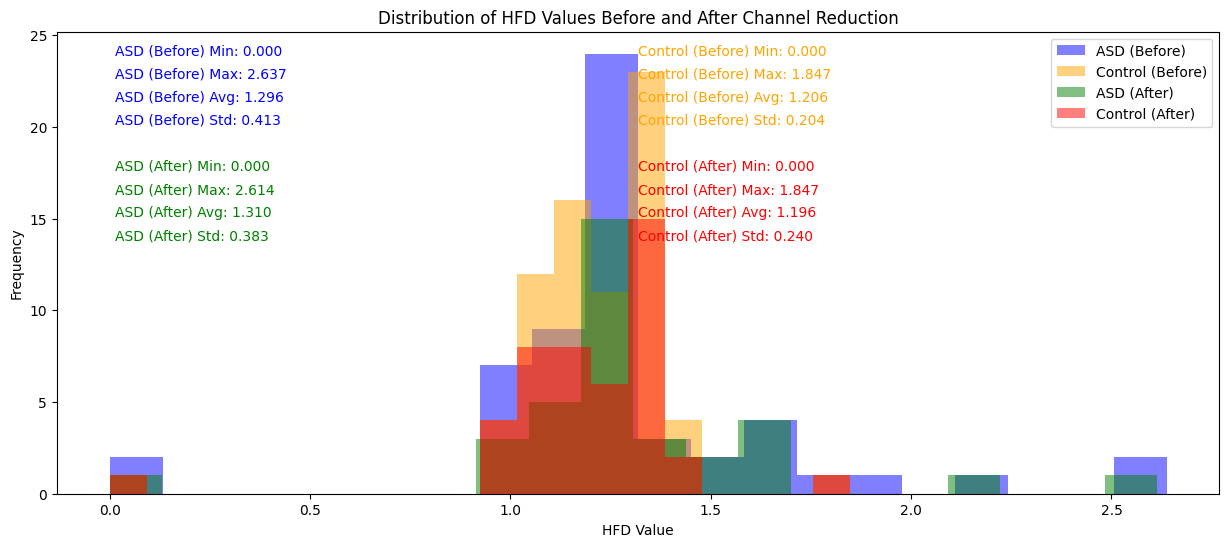

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# Read ASD and Control data without channel reduction
asd_df_before = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv')
control_df_before = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv')

# Read ASD and Control data after channel reduction
asd_df_after = pd.read_csv('EEG Data/ASD/HFD_ASD/HFD_ASD_2.csv')[cols]
control_df_after = pd.read_csv('EEG Data/Control/HFD_Control/HFD_Control_2.csv')[cols]

# Plot histograms for both conditions in one figure
plt.figure(figsize=(15, 6))

# Plot histograms for before channel reduction
plt.hist(asd_df_before.values.flatten(), bins=20, alpha=0.5, color='blue', label='ASD (Before)')
plt.hist(control_df_before.values.flatten(), bins=20, alpha=0.5, color='orange', label='Control (Before)')

# Plot histograms for after channel reduction
plt.hist(asd_df_after.values.flatten(), bins=20, alpha=0.5, color='green', label='ASD (After)')
plt.hist(control_df_after.values.flatten(), bins=20, alpha=0.5, color='red', label='Control (After)')

# Add text annotations for statistics
plt.text(0.05, 0.95, f"ASD (Before) Min: {asd_df_before.values.min():.3f}", transform=plt.gca().transAxes, color='blue')
plt.text(0.05, 0.9, f"ASD (Before) Max: {asd_df_before.values.max():.3f}", transform=plt.gca().transAxes, color='blue')
plt.text(0.05, 0.85, f"ASD (Before) Avg: {asd_df_before.values.mean():.3f}", transform=plt.gca().transAxes, color='blue')
plt.text(0.05, 0.8, f"ASD (Before) Std: {asd_df_before.values.std():.3f}", transform=plt.gca().transAxes, color='blue')

plt.text(0.5, 0.95, f"Control (Before) Min: {control_df_before.values.min():.3f}", transform=plt.gca().transAxes, color='orange')
plt.text(0.5, 0.9, f"Control (Before) Max: {control_df_before.values.max():.3f}", transform=plt.gca().transAxes, color='orange')
plt.text(0.5, 0.85, f"Control (Before) Avg: {control_df_before.values.mean():.3f}", transform=plt.gca().transAxes, color='orange')
plt.text(0.5, 0.8, f"Control (Before) Std: {control_df_before.values.std():.3f}", transform=plt.gca().transAxes, color='orange')

plt.text(0.05, 0.7, f"ASD (After) Min: {asd_df_after.values.min():.3f}", transform=plt.gca().transAxes, color='green')
plt.text(0.05, 0.65, f"ASD (After) Max: {asd_df_after.values.max():.3f}", transform=plt.gca().transAxes, color='green')
plt.text(0.05, 0.6, f"ASD (After) Avg: {asd_df_after.values.mean():.3f}", transform=plt.gca().transAxes, color='green')
plt.text(0.05, 0.55, f"ASD (After) Std: {asd_df_after.values.std():.3f}", transform=plt.gca().transAxes, color='green')

plt.text(0.5, 0.7, f"Control (After) Min: {control_df_after.values.min():.3f}", transform=plt.gca().transAxes, color='red')
plt.text(0.5, 0.65, f"Control (After) Max: {control_df_after.values.max():.3f}", transform=plt.gca().transAxes, color='red')
plt.text(0.5, 0.6, f"Control (After) Avg: {control_df_after.values.mean():.3f}", transform=plt.gca().transAxes, color='red')
plt.text(0.5, 0.55, f"Control (After) Std: {control_df_after.values.std():.3f}", transform=plt.gca().transAxes, color='red')

plt.title('Distribution of HFD Values Before and After Channel Reduction')
plt.xlabel('HFD Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()


# All HFD Patient

In [114]:
dfa = pd.read_csv('EEG Data/HFD_ASD_Control.csv') # all 16 patients within a file
dfa

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8,Class
0,1.020497,1.917996,1.349071,0.000000,1.923019,1.216372,1.748945,1.069162,1
1,1.706968,1.625886,1.827281,1.393598,1.438352,1.400129,1.723234,1.455506,1
2,1.010099,1.002608,1.001369,1.061762,0.000000,1.028190,1.254981,1.000309,1
3,1.843649,2.267780,2.021265,2.038527,1.907534,1.772715,1.832807,1.389427,1
4,1.486485,1.510619,1.383923,1.852370,1.806557,1.818844,1.997518,1.534451,1
...,...,...,...,...,...,...,...,...,...
155,1.031630,1.298082,1.206036,1.262295,1.109554,1.013371,1.269579,0.248653,0
156,1.031630,1.298082,1.206036,1.262295,1.109554,1.013371,1.269579,0.000000,0
157,1.045466,1.014359,1.037253,1.012867,1.022402,1.029425,1.018031,1.012945,0
158,1.036322,1.020239,1.227959,1.078080,1.101483,1.107782,1.053650,1.063549,0


# Randomly Generate For Train and Tesing

In [115]:
import pandas

# Randomly sample 70% of your dataframe
df_percent = dfa.sample(frac=0.8)
df_percent
# Randomly sample 7 elements from your dataframe
#df_elements = df.sample(n=7)

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8,Class
156,1.031630,1.298082,1.206036,1.262295,1.109554,1.013371,1.269579,0.000000,0
148,1.068043,1.019893,1.041739,1.017728,1.019137,1.036777,1.013230,1.012619,0
128,-1.287892,-1.057709,-1.148216,-1.154674,-1.099841,-1.070677,-1.203287,-1.102649,0
51,1.024868,1.009833,1.004414,1.167069,0.000000,1.117847,1.118876,1.015102,1
129,-1.287892,-1.057709,-1.148216,-1.154674,-1.099841,-1.070677,-1.203287,0.000000,0
...,...,...,...,...,...,...,...,...,...
40,1.741968,1.781306,1.775208,1.733027,1.771395,1.752246,1.773108,1.735315,1
112,1.112420,1.039227,1.055550,1.049690,1.020937,1.076666,1.009106,1.017519,0
27,-1.074681,-0.963552,-1.097988,-1.009628,-1.347904,-0.748401,-0.831323,-0.918681,1
150,1.390273,1.254404,1.816155,1.533095,1.697692,1.703420,1.477905,1.666303,0


In [116]:
df_rest = dfa.loc[~dfa.index.isin(df_percent.index)]
df_rest

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8,Class
9,1.027105,1.006810,1.003675,1.116483,0.000000,1.086137,1.136159,1.005239,1
12,1.578057,1.675960,1.635035,1.605858,1.623870,1.615763,1.629214,1.563121,1
14,1.051674,1.991607,1.163811,0.000000,1.991944,1.132468,1.371554,1.263794,1
19,1.639309,1.715780,1.692900,1.648214,1.682826,1.672105,1.684881,1.629948,1
30,1.007617,1.001238,1.001041,1.042725,0.000000,1.016467,1.184509,1.000074,1
39,1.780490,1.785488,1.706559,1.864485,1.853453,1.856114,1.924700,1.789430,1
42,1.089227,1.996148,1.132987,0.000000,1.996114,1.174750,1.375530,1.438733,1
46,1.793353,1.794585,1.733587,1.873599,1.863999,1.866194,1.928087,1.800738,1
60,1.464757,1.496399,1.386753,1.717759,1.684191,1.692368,1.862690,1.504184,1
68,1.421807,1.591407,1.523062,1.438078,1.483631,1.459795,1.487903,1.399552,1


# For Tarin and Test

In [117]:
df_percent1 = dfa.sample(frac=0.8)
df_rest1 = dfa.loc[~dfa.index.isin(df_percent1.index)]
df_percent2 = dfa.sample(frac=0.8)
df_rest2 = dfa.loc[~dfa.index.isin(df_percent2.index)]
df_percent3 = dfa.sample(frac=0.8)
df_rest3 = dfa.loc[~dfa.index.isin(df_percent3.index)]
df_percent4 = dfa.sample(frac=0.8)
df_rest4 = dfa.loc[~dfa.index.isin(df_percent4.index)]
df_percent5 = dfa.sample(frac=0.8)
df_rest5 = dfa.loc[~dfa.index.isin(df_percent5.index)]

In [118]:
df_percent1.to_csv('EEG Data/Train/df_percent1.csv',index=False)
df_percent2.to_csv('EEG Data/Train/df_percent2.csv',index=False)
df_percent3.to_csv('EEG Data/Train/df_percent3.csv',index=False)
df_percent4.to_csv('EEG Data/Train/df_percent4.csv',index=False)
df_percent5.to_csv('EEG Data/Train/df_percent5.csv',index=False)

In [119]:
df_percent1 = pd.read_csv('EEG Data/Train/df_percent1.csv')
df_percent2 = pd.read_csv('EEG Data/Train/df_percent2.csv')
df_percent3 = pd.read_csv('EEG Data/Train/df_percent3.csv')
df_percent4 = pd.read_csv('EEG Data/Train/df_percent4.csv')
df_percent5 = pd.read_csv('EEG Data/Train/df_percent5.csv')

In [120]:
df_percent1

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8,Class
0,1.952233,1.966199,1.947332,1.958862,1.959156,1.958678,1.959106,1.959719,0
1,1.845321,1.709780,1.870331,1.891501,1.863501,1.889295,1.882020,1.817812,0
2,1.188641,1.354464,1.257411,1.294776,1.096950,1.264200,1.194478,1.185693,0
3,1.391468,1.556642,1.455388,1.730619,1.420253,1.745519,1.556076,1.613134,0
4,1.741968,1.781306,1.775208,1.733027,1.771395,1.752246,1.773108,1.735315,1
...,...,...,...,...,...,...,...,...,...
123,1.628156,1.974019,2.014045,1.814594,1.697001,1.595039,1.625161,1.452072,1
124,1.421807,1.591407,1.523062,1.438078,1.483631,1.459795,1.487903,1.399552,1
125,1.639309,1.715780,1.692900,1.648214,1.682826,1.672105,1.684881,1.629948,1
126,1.874242,1.993200,2.030603,1.952057,1.920641,1.894148,1.901337,1.867401,1


In [121]:
df_rest1.to_csv('EEG Data/Test/df_rest1.csv',index=False)
df_rest2.to_csv('EEG Data/Test/df_rest2.csv',index=False)
df_rest3.to_csv('EEG Data/Test/df_rest3.csv',index=False)
df_rest4.to_csv('EEG Data/Test/df_rest4.csv',index=False)
df_rest5.to_csv('EEG Data/Test/df_rest5.csv',index=False)

In [122]:
df_rest1 = pd.read_csv('EEG Data/Test/df_rest1.csv')
df_rest2 = pd.read_csv('EEG Data/Test/df_rest2.csv')
df_rest3 = pd.read_csv('EEG Data/Test/df_rest3.csv')
df_rest4 = pd.read_csv('EEG Data/Test/df_rest4.csv')
df_rest5 = pd.read_csv('EEG Data/Test/df_rest5.csv')

In [123]:
df_rest1

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8,Class
0,1.706968,1.625886,1.827281,1.393598,1.438352,1.400129,1.723234,1.455506,1
1,1.843649,2.267780,2.021265,2.038527,1.907534,1.772715,1.832807,1.389427,1
2,1.486485,1.510619,1.383923,1.852370,1.806557,1.818844,1.997518,1.534451,1
3,1.736462,1.972073,2.015940,1.853128,1.784581,1.743909,1.749381,1.629815,1
4,1.693332,1.695282,1.567311,1.810258,1.793093,1.794570,1.901031,1.718983,1
5,1.578057,1.675960,1.635035,1.605858,1.623870,1.615763,1.629214,1.563121,1
6,-0.947149,-0.829631,-0.994459,-0.869328,-1.248166,-0.584332,-0.661044,-0.739441,1
7,1.830527,1.976829,2.022473,1.897489,1.847656,1.813753,1.816714,1.729720,1
8,1.007617,1.001238,1.001041,1.042725,0.000000,1.016467,1.184509,1.000074,1
9,1.026086,1.009077,1.004506,1.148242,0.000000,1.110843,1.120095,1.011438,1


In [124]:
import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

In [125]:
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=8))
#model.add(Dense(13, activation='relu'))
#model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [126]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 112 (448.00 Byte)
Trainable params: 112 (448.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Accuracy Check Fisrt

Epoch 1/400
4/4 [==============================] - 2s 97ms/step - loss: 0.6956 - accuracy: 0.6016 - val_loss: 0.6958 - val_accuracy: 0.5312
Epoch 2/400
4/4 [==============================] - 0s 15ms/step - loss: 0.6887 - accuracy: 0.6797 - val_loss: 0.6895 - val_accuracy: 0.5938
Epoch 3/400
4/4 [==============================] - 0s 17ms/step - loss: 0.6853 - accuracy: 0.6484 - val_loss: 0.6830 - val_accuracy: 0.7500
Epoch 4/400
4/4 [==============================] - 0s 19ms/step - loss: 0.6809 - accuracy: 0.7188 - val_loss: 0.6778 - val_accuracy: 0.7500
Epoch 5/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6773 - accuracy: 0.6953 - val_loss: 0.6733 - val_accuracy: 0.7500
Epoch 6/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6748 - accuracy: 0.6797 - val_loss: 0.6695 - val_accuracy: 0.7500
Epoch 7/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6720 - accuracy: 0.6797 - val_loss: 0.6662 - val_accuracy: 0.7188
Epoch 8/400
4/4 [===

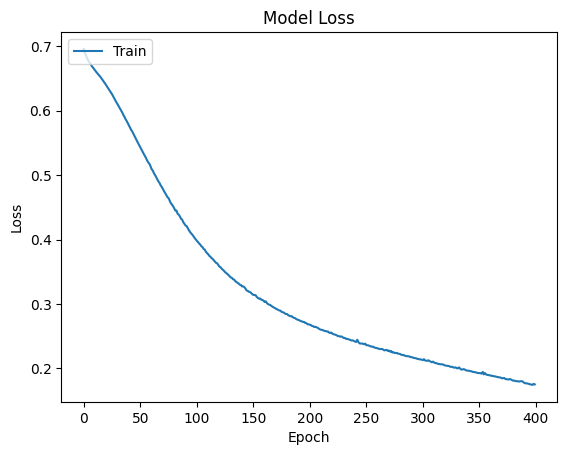

1/1 [==============================] - 0s 24ms/step
      Metric      Train   Test
0   Accuracy  96.093750  100.0
1  Precision   0.961098    1.0
2     Recall   0.960938    1.0
3   F1 Score   0.960959    1.0

Confusion Matrix for Train Data:
 [[66  3]
 [ 2 57]]

Confusion Matrix for Test Data:
 [[21  0]
 [ 0 11]]


In [127]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Data preparation
x_train = df_percent1.drop(["Class"], axis=1).values
y_train = df_percent1["Class"].values
x_test = df_rest1.drop(["Class"], axis=1).values
y_test = df_rest1["Class"].values

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape data for LSTM
timesteps = 1  # Each sample has 1 timestep
features = x_train.shape[1]  # Number of features

x_train = x_train.reshape((x_train.shape[0], timesteps, features))
x_test = x_test.reshape((x_test.shape[0], timesteps, features))

# Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=400, validation_data=(x_test, y_test))

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Evaluate model
pred_train = model.predict(x_train)
predict_classes1 = np.argmax(pred_train, axis=1)
expected_classes1 = np.argmax(y_train, axis=1)

# Calculate metrics for training data
accuracy_train = accuracy_score(expected_classes1, predict_classes1)
precision_train = precision_score(expected_classes1, predict_classes1, average='weighted')
recall_train = recall_score(expected_classes1, predict_classes1, average='weighted')
f1_train = f1_score(expected_classes1, predict_classes1, average='weighted')
conf_matrix_train = confusion_matrix(expected_classes1, predict_classes1)

pred_test = model.predict(x_test)
predict_classes2 = np.argmax(pred_test, axis=1)
expected_classes2 = np.argmax(y_test, axis=1)

# Calculate metrics for test data
accuracy_test = accuracy_score(expected_classes2, predict_classes2)
precision_test = precision_score(expected_classes2, predict_classes2, average='weighted')
recall_test = recall_score(expected_classes2, predict_classes2, average='weighted')
f1_test = f1_score(expected_classes2, predict_classes2, average='weighted')
conf_matrix_test = confusion_matrix(expected_classes2, predict_classes2)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_train * 100, precision_train, recall_train, f1_train],
    'Test': [accuracy_test * 100, precision_test, recall_test, f1_test]
})

print(metrics_df)

# Print confusion matrices
print('\nConfusion Matrix for Train Data:\n', conf_matrix_train)
print('\nConfusion Matrix for Test Data:\n', conf_matrix_test)




# Accuracy Check Second

Epoch 1/400
4/4 [==============================] - 2s 100ms/step - loss: 0.6878 - accuracy: 0.5859 - val_loss: 0.6851 - val_accuracy: 0.5625
Epoch 2/400
4/4 [==============================] - 0s 17ms/step - loss: 0.6811 - accuracy: 0.6328 - val_loss: 0.6876 - val_accuracy: 0.5625
Epoch 3/400
4/4 [==============================] - 0s 17ms/step - loss: 0.6773 - accuracy: 0.6406 - val_loss: 0.6906 - val_accuracy: 0.5625
Epoch 4/400
4/4 [==============================] - 0s 15ms/step - loss: 0.6735 - accuracy: 0.6406 - val_loss: 0.6937 - val_accuracy: 0.5625
Epoch 5/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6697 - accuracy: 0.6406 - val_loss: 0.6964 - val_accuracy: 0.5625
Epoch 6/400
4/4 [==============================] - 0s 15ms/step - loss: 0.6665 - accuracy: 0.6406 - val_loss: 0.6986 - val_accuracy: 0.5625
Epoch 7/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6652 - accuracy: 0.6406 - val_loss: 0.7021 - val_accuracy: 0.5625
Epoch 8/400
4/4 [==

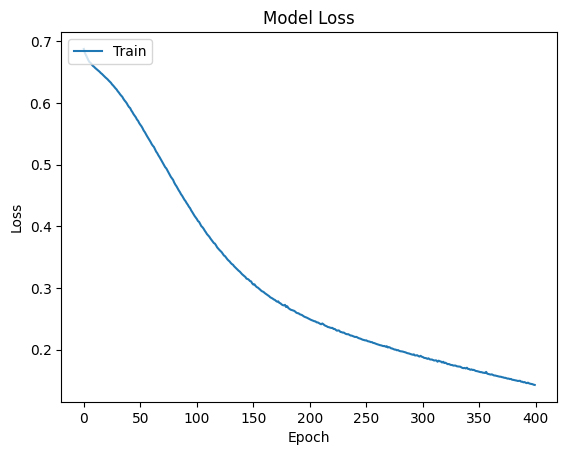

1/1 [==============================] - 0s 22ms/step
      Metric      Train       Test
0   Accuracy  96.093750  96.875000
1  Precision   0.960945   0.970703
2     Recall   0.960938   0.968750
3   F1 Score   0.960881   0.968781

Confusion Matrix for Train Data:
 [[73  2]
 [ 3 50]]

Confusion Matrix for Test Data:
 [[15  0]
 [ 1 16]]


In [128]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
x_train = df_percent2.drop(["Class"], axis=1).values
y_train = df_percent2["Class"].values
x_test = df_rest2.drop(["Class"], axis=1).values
y_test = df_rest2["Class"].values

# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert class vectors to one-hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape data for LSTM
timesteps = 1  # Each sample has 1 timestep (for this example)
features = x_train.shape[1]  # Number of features

x_train = x_train.reshape((x_train.shape[0], timesteps, features))
x_test = x_test.reshape((x_test.shape[0], timesteps, features))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=400, validation_data=(x_test, y_test))

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Evaluate model on train data
pred_train = model.predict(x_train)
predict_classes1 = np.argmax(pred_train, axis=1)
expected_classes1 = np.argmax(y_train, axis=1)

# Calculate metrics for training data
accuracy_train = accuracy_score(expected_classes1, predict_classes1)
precision_train = precision_score(expected_classes1, predict_classes1, average='weighted')
recall_train = recall_score(expected_classes1, predict_classes1, average='weighted')
f1_train = f1_score(expected_classes1, predict_classes1, average='weighted')
conf_matrix_train = confusion_matrix(expected_classes1, predict_classes1)

# Evaluate model on test data
pred_test = model.predict(x_test)
predict_classes2 = np.argmax(pred_test, axis=1)
expected_classes2 = np.argmax(y_test, axis=1)

# Calculate metrics for test data
accuracy_test = accuracy_score(expected_classes2, predict_classes2)
precision_test = precision_score(expected_classes2, predict_classes2, average='weighted')
recall_test = recall_score(expected_classes2, predict_classes2, average='weighted')
f1_test = f1_score(expected_classes2, predict_classes2, average='weighted')
conf_matrix_test = confusion_matrix(expected_classes2, predict_classes2)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_train * 100, precision_train, recall_train, f1_train],
    'Test': [accuracy_test * 100, precision_test, recall_test, f1_test]
})

print(metrics_df)

# Print confusion matrices
print('\nConfusion Matrix for Train Data:\n', conf_matrix_train)
print('\nConfusion Matrix for Test Data:\n', conf_matrix_test)


# Accurcay Check Third

Epoch 1/400
4/4 [==============================] - 2s 89ms/step - loss: 0.6954 - accuracy: 0.4141 - val_loss: 0.6920 - val_accuracy: 0.5312
Epoch 2/400
4/4 [==============================] - 0s 13ms/step - loss: 0.6904 - accuracy: 0.6250 - val_loss: 0.6890 - val_accuracy: 0.6250
Epoch 3/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6866 - accuracy: 0.6016 - val_loss: 0.6861 - val_accuracy: 0.6562
Epoch 4/400
4/4 [==============================] - 0s 15ms/step - loss: 0.6828 - accuracy: 0.6016 - val_loss: 0.6837 - val_accuracy: 0.6562
Epoch 5/400
4/4 [==============================] - 0s 13ms/step - loss: 0.6800 - accuracy: 0.6094 - val_loss: 0.6817 - val_accuracy: 0.6562
Epoch 6/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6776 - accuracy: 0.6094 - val_loss: 0.6799 - val_accuracy: 0.6562
Epoch 7/400
4/4 [==============================] - 0s 13ms/step - loss: 0.6756 - accuracy: 0.6172 - val_loss: 0.6780 - val_accuracy: 0.6562
Epoch 8/400
4/4 [===

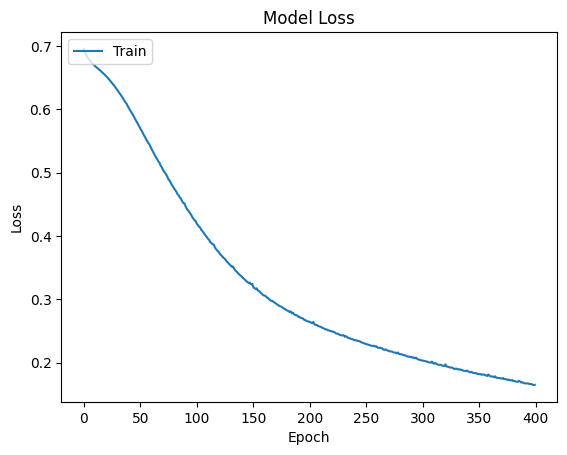

1/1 [==============================] - 0s 28ms/step
      Metric     Train       Test
0   Accuracy  96.87500  93.750000
1  Precision   0.96875   0.945833
2     Recall   0.96875   0.937500
3   F1 Score   0.96875   0.937996

Confusion Matrix for Train Data:
 [[69  2]
 [ 2 55]]

Confusion Matrix for Test Data:
 [[17  2]
 [ 0 13]]


In [129]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
x_train = df_percent3.drop(["Class"], axis=1).values
y_train = df_percent3["Class"].values
x_test = df_rest3.drop(["Class"], axis=1).values
y_test = df_rest3["Class"].values

# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert class vectors to one-hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape data for LSTM
timesteps = 1  # Each sample has 1 timestep (for this example)
features = x_train.shape[1]  # Number of features

x_train = x_train.reshape((x_train.shape[0], timesteps, features))
x_test = x_test.reshape((x_test.shape[0], timesteps, features))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=400, validation_data=(x_test, y_test))

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Evaluate model on train data
pred_train = model.predict(x_train)
predict_classes1 = np.argmax(pred_train, axis=1)
expected_classes1 = np.argmax(y_train, axis=1)

# Calculate metrics for training data
accuracy_train = accuracy_score(expected_classes1, predict_classes1)
precision_train = precision_score(expected_classes1, predict_classes1, average='weighted')
recall_train = recall_score(expected_classes1, predict_classes1, average='weighted')
f1_train = f1_score(expected_classes1, predict_classes1, average='weighted')
conf_matrix_train = confusion_matrix(expected_classes1, predict_classes1)

# Evaluate model on test data
pred_test = model.predict(x_test)
predict_classes2 = np.argmax(pred_test, axis=1)
expected_classes2 = np.argmax(y_test, axis=1)

# Calculate metrics for test data
accuracy_test = accuracy_score(expected_classes2, predict_classes2)
precision_test = precision_score(expected_classes2, predict_classes2, average='weighted')
recall_test = recall_score(expected_classes2, predict_classes2, average='weighted')
f1_test = f1_score(expected_classes2, predict_classes2, average='weighted')
conf_matrix_test = confusion_matrix(expected_classes2, predict_classes2)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_train * 100, precision_train, recall_train, f1_train],
    'Test': [accuracy_test * 100, precision_test, recall_test, f1_test]
})

print(metrics_df)

# Print confusion matrices
print('\nConfusion Matrix for Train Data:\n', conf_matrix_train)
print('\nConfusion Matrix for Test Data:\n', conf_matrix_test)


# Accuracy Check Fourth

Epoch 1/400
4/4 [==============================] - 2s 102ms/step - loss: 0.6894 - accuracy: 0.5391 - val_loss: 0.6943 - val_accuracy: 0.4375
Epoch 2/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6850 - accuracy: 0.6328 - val_loss: 0.6886 - val_accuracy: 0.6875
Epoch 3/400
4/4 [==============================] - 0s 15ms/step - loss: 0.6818 - accuracy: 0.6875 - val_loss: 0.6819 - val_accuracy: 0.6875
Epoch 4/400
4/4 [==============================] - 0s 13ms/step - loss: 0.6787 - accuracy: 0.6875 - val_loss: 0.6767 - val_accuracy: 0.6875
Epoch 5/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6756 - accuracy: 0.6797 - val_loss: 0.6737 - val_accuracy: 0.6875
Epoch 6/400
4/4 [==============================] - 0s 13ms/step - loss: 0.6735 - accuracy: 0.6797 - val_loss: 0.6707 - val_accuracy: 0.6562
Epoch 7/400
4/4 [==============================] - 0s 15ms/step - loss: 0.6722 - accuracy: 0.6484 - val_loss: 0.6681 - val_accuracy: 0.5938
Epoch 8/400
4/4 [==

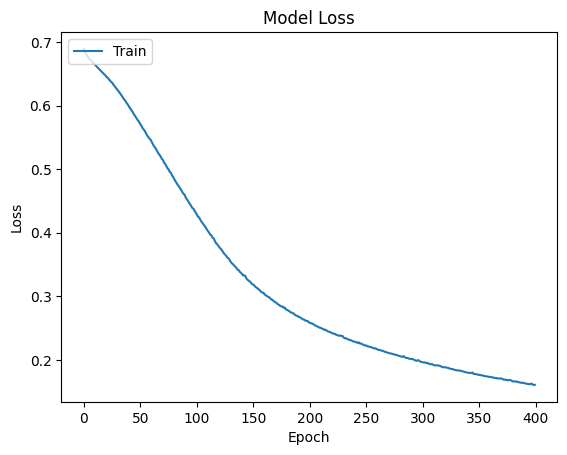

1/1 [==============================] - 0s 30ms/step
      Metric      Train       Test
0   Accuracy  98.437500  87.500000
1  Precision   0.984375   0.882812
2     Recall   0.984375   0.875000
3   F1 Score   0.984375   0.875490

Confusion Matrix for Train Data:
 [[71  1]
 [ 1 55]]

Confusion Matrix for Test Data:
 [[15  3]
 [ 1 13]]


In [130]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
x_train = df_percent4.drop(["Class"], axis=1).values
y_train = df_percent4["Class"].values
x_test = df_rest4.drop(["Class"], axis=1).values
y_test = df_rest4["Class"].values

# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert class vectors to one-hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape data for LSTM
timesteps = 1  # Each sample has 1 timestep (for this example)
features = x_train.shape[1]  # Number of features

x_train = x_train.reshape((x_train.shape[0], timesteps, features))
x_test = x_test.reshape((x_test.shape[0], timesteps, features))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=400, validation_data=(x_test, y_test))

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Evaluate model on train data
pred_train = model.predict(x_train)
predict_classes1 = np.argmax(pred_train, axis=1)
expected_classes1 = np.argmax(y_train, axis=1)

# Calculate metrics for training data
accuracy_train = accuracy_score(expected_classes1, predict_classes1)
precision_train = precision_score(expected_classes1, predict_classes1, average='weighted')
recall_train = recall_score(expected_classes1, predict_classes1, average='weighted')
f1_train = f1_score(expected_classes1, predict_classes1, average='weighted')
conf_matrix_train = confusion_matrix(expected_classes1, predict_classes1)

# Evaluate model on test data
pred_test = model.predict(x_test)
predict_classes2 = np.argmax(pred_test, axis=1)
expected_classes2 = np.argmax(y_test, axis=1)

# Calculate metrics for test data
accuracy_test = accuracy_score(expected_classes2, predict_classes2)
precision_test = precision_score(expected_classes2, predict_classes2, average='weighted')
recall_test = recall_score(expected_classes2, predict_classes2, average='weighted')
f1_test = f1_score(expected_classes2, predict_classes2, average='weighted')
conf_matrix_test = confusion_matrix(expected_classes2, predict_classes2)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_train * 100, precision_train, recall_train, f1_train],
    'Test': [accuracy_test * 100, precision_test, recall_test, f1_test]
})

print(metrics_df)

# Print confusion matrices
print('\nConfusion Matrix for Train Data:\n', conf_matrix_train)
print('\nConfusion Matrix for Test Data:\n', conf_matrix_test)


# Accuracy Check Five

Epoch 1/400
4/4 [==============================] - 2s 114ms/step - loss: 0.6935 - accuracy: 0.5156 - val_loss: 0.6893 - val_accuracy: 0.5312
Epoch 2/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6891 - accuracy: 0.5781 - val_loss: 0.6871 - val_accuracy: 0.6250
Epoch 3/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6851 - accuracy: 0.6094 - val_loss: 0.6853 - val_accuracy: 0.6250
Epoch 4/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6823 - accuracy: 0.6094 - val_loss: 0.6836 - val_accuracy: 0.6250
Epoch 5/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6788 - accuracy: 0.6094 - val_loss: 0.6823 - val_accuracy: 0.6250
Epoch 6/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6770 - accuracy: 0.6094 - val_loss: 0.6816 - val_accuracy: 0.6250
Epoch 7/400
4/4 [==============================] - 0s 14ms/step - loss: 0.6740 - accuracy: 0.6094 - val_loss: 0.6809 - val_accuracy: 0.6250
Epoch 8/400
4/4 [==

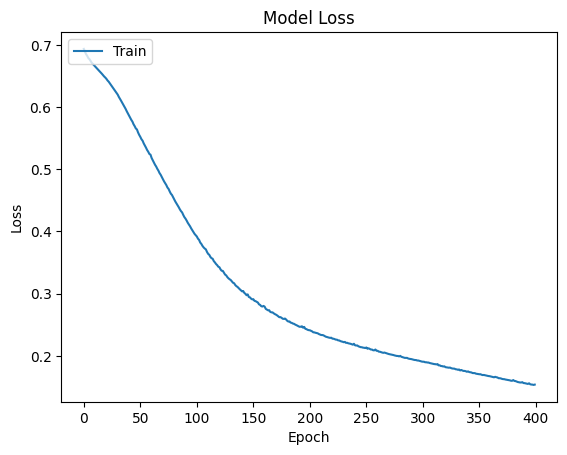

1/1 [==============================] - 0s 25ms/step
      Metric      Train       Test
0   Accuracy  95.312500  84.375000
1  Precision   0.953125   0.846974
2     Recall   0.953125   0.843750
3   F1 Score   0.953125   0.844532

Confusion Matrix for Train Data:
 [[68  3]
 [ 3 54]]

Confusion Matrix for Test Data:
 [[16  3]
 [ 2 11]]


In [131]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
x_train = df_percent5.drop(["Class"], axis=1).values
y_train = df_percent5["Class"].values
x_test = df_rest5.drop(["Class"], axis=1).values
y_test = df_rest5["Class"].values

# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert class vectors to one-hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape data for LSTM
timesteps = 1  # Each sample has 1 timestep (for this example)
features = x_train.shape[1]  # Number of features

x_train = x_train.reshape((x_train.shape[0], timesteps, features))
x_test = x_test.reshape((x_test.shape[0], timesteps, features))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=400, validation_data=(x_test, y_test))

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Evaluate model on train data
pred_train = model.predict(x_train)
predict_classes1 = np.argmax(pred_train, axis=1)
expected_classes1 = np.argmax(y_train, axis=1)

# Calculate metrics for training data
accuracy_train = accuracy_score(expected_classes1, predict_classes1)
precision_train = precision_score(expected_classes1, predict_classes1, average='weighted')
recall_train = recall_score(expected_classes1, predict_classes1, average='weighted')
f1_train = f1_score(expected_classes1, predict_classes1, average='weighted')
conf_matrix_train = confusion_matrix(expected_classes1, predict_classes1)

# Evaluate model on test data
pred_test = model.predict(x_test)
predict_classes2 = np.argmax(pred_test, axis=1)
expected_classes2 = np.argmax(y_test, axis=1)

# Calculate metrics for test data
accuracy_test = accuracy_score(expected_classes2, predict_classes2)
precision_test = precision_score(expected_classes2, predict_classes2, average='weighted')
recall_test = recall_score(expected_classes2, predict_classes2, average='weighted')
f1_test = f1_score(expected_classes2, predict_classes2, average='weighted')
conf_matrix_test = confusion_matrix(expected_classes2, predict_classes2)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_train * 100, precision_train, recall_train, f1_train],
    'Test': [accuracy_test * 100, precision_test, recall_test, f1_test]
})

print(metrics_df)

# Print confusion matrices
print('\nConfusion Matrix for Train Data:\n', conf_matrix_train)
print('\nConfusion Matrix for Test Data:\n', conf_matrix_test)

# Average Accuracy Check for 5 randomely Dataset from dfa

Processing dataset pair 1/5
1/1 [==============================] - 0s 19ms/step
Processing dataset pair 2/5
1/1 [==============================] - 0s 19ms/step
Processing dataset pair 3/5
1/1 [==============================] - 0s 19ms/step
Processing dataset pair 4/5
1/1 [==============================] - 0s 19ms/step
Processing dataset pair 5/5
1/1 [==============================] - 0s 20ms/step


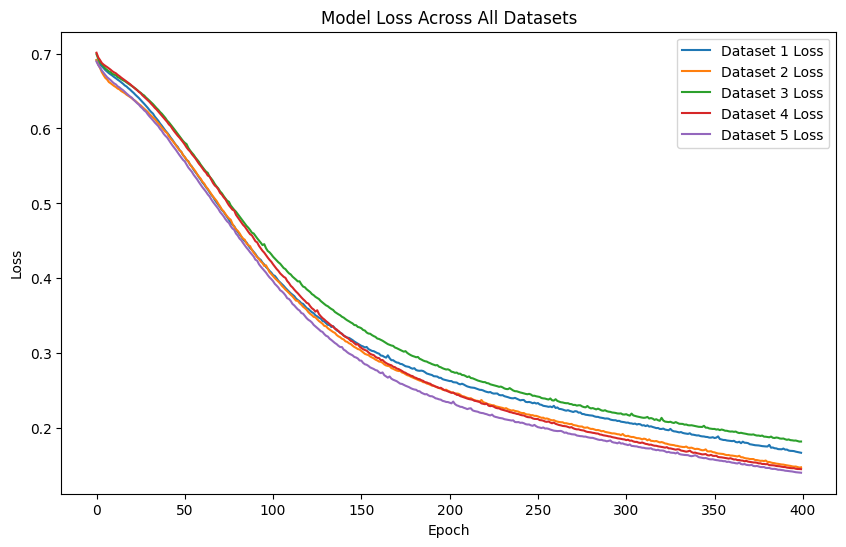

Average Metrics across all datasets:
      Metric      Train       Test
0   Accuracy  96.093750  93.750000
1  Precision   0.961211   0.941649
2     Recall   0.960938   0.937500
3   F1 Score   0.960874   0.937748


In [132]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Define the list of dataset pairs
df_percent_list = [df_percent1, df_percent2, df_percent3, df_percent4, df_percent5]
df_rest_list = [df_rest1, df_rest2, df_rest3, df_rest4, df_rest5]

# Initialize accumulators for metrics and history
total_accuracy_train = 0
total_precision_train = 0
total_recall_train = 0
total_f1_train = 0

total_accuracy_test = 0
total_precision_test = 0
total_recall_test = 0
total_f1_test = 0

n_datasets = len(df_percent_list)

# Initialize plot for loss
plt.figure(figsize=(10, 6))

# Loop through each dataset pair
for i in range(n_datasets):
    print(f"Processing dataset pair {i+1}/{n_datasets}")
    
    # Prepare data
    x_train = df_percent_list[i].drop(["Class"], axis=1).values
    y_train = df_percent_list[i]["Class"].values
    x_test = df_rest_list[i].drop(["Class"], axis=1).values
    y_test = df_rest_list[i]["Class"].values

    # Scale the features
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Convert class vectors to one-hot encoded format
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Reshape data for LSTM
    timesteps = 1  # Each sample has 1 timestep (for this example)
    features = x_train.shape[1]  # Number of features

    x_train = x_train.reshape((x_train.shape[0], timesteps, features))
    x_test = x_test.reshape((x_test.shape[0], timesteps, features))

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train, epochs=400, verbose=0, validation_data=(x_test, y_test))

    # Plot the loss for each dataset
    plt.plot(history.history['loss'], label=f'Dataset {i+1} Loss')

    # Evaluate model on train data
    pred_train = model.predict(x_train)
    predict_classes1 = np.argmax(pred_train, axis=1)
    expected_classes1 = np.argmax(y_train, axis=1)

    # Calculate metrics for training data
    accuracy_train = accuracy_score(expected_classes1, predict_classes1)
    precision_train = precision_score(expected_classes1, predict_classes1, average='weighted')
    recall_train = recall_score(expected_classes1, predict_classes1, average='weighted')
    f1_train = f1_score(expected_classes1, predict_classes1, average='weighted')

    # Accumulate train metrics
    total_accuracy_train += accuracy_train
    total_precision_train += precision_train
    total_recall_train += recall_train
    total_f1_train += f1_train

    # Evaluate model on test data
    pred_test = model.predict(x_test)
    predict_classes2 = np.argmax(pred_test, axis=1)
    expected_classes2 = np.argmax(y_test, axis=1)

    # Calculate metrics for test data
    accuracy_test = accuracy_score(expected_classes2, predict_classes2)
    precision_test = precision_score(expected_classes2, predict_classes2, average='weighted')
    recall_test = recall_score(expected_classes2, predict_classes2, average='weighted')
    f1_test = f1_score(expected_classes2, predict_classes2, average='weighted')

    # Accumulate test metrics
    total_accuracy_test += accuracy_test
    total_precision_test += precision_test
    total_recall_test += recall_test
    total_f1_test += f1_test

# Show the loss plot
plt.title('Model Loss Across All Datasets')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Calculate average metrics for training data
average_accuracy_train = total_accuracy_train / n_datasets
average_precision_train = total_precision_train / n_datasets
average_recall_train = total_recall_train / n_datasets
average_f1_train = total_f1_train / n_datasets

# Calculate average metrics for test data
average_accuracy_test = total_accuracy_test / n_datasets
average_precision_test = total_precision_test / n_datasets
average_recall_test = total_recall_test / n_datasets
average_f1_test = total_f1_test / n_datasets

# Create a DataFrame to display the average metrics
average_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [average_accuracy_train * 100, average_precision_train, average_recall_train, average_f1_train],
    'Test': [average_accuracy_test * 100, average_precision_test, average_recall_test, average_f1_test]
})

print("Average Metrics across all datasets:")
print(average_metrics_df)


# Average Accuracy for dfa

In [133]:
dfa

,HFD_CH1,HFD_CH2,HFD_CH3,HFD_CH4,HFD_CH5,HFD_CH6,HFD_CH7,HFD_CH8,Class
0,1.020497,1.917996,1.349071,0.000000,1.923019,1.216372,1.748945,1.069162,1
1,1.706968,1.625886,1.827281,1.393598,1.438352,1.400129,1.723234,1.455506,1
2,1.010099,1.002608,1.001369,1.061762,0.000000,1.028190,1.254981,1.000309,1
3,1.843649,2.267780,2.021265,2.038527,1.907534,1.772715,1.832807,1.389427,1
4,1.486485,1.510619,1.383923,1.852370,1.806557,1.818844,1.997518,1.534451,1
...,...,...,...,...,...,...,...,...,...
155,1.031630,1.298082,1.206036,1.262295,1.109554,1.013371,1.269579,0.248653,0
156,1.031630,1.298082,1.206036,1.262295,1.109554,1.013371,1.269579,0.000000,0
157,1.045466,1.014359,1.037253,1.012867,1.022402,1.029425,1.018031,1.012945,0
158,1.036322,1.020239,1.227959,1.078080,1.101483,1.107782,1.053650,1.063549,0


In [134]:
dfa1 = np.array(dfa)
dfa1

array([[1.02049745, 1.91799627, 1.34907094, ..., 1.74894537, 1.06916217,
        1.        ],
       [1.7069683 , 1.62588584, 1.82728146, ..., 1.72323385, 1.4555065 ,
        1.        ],
       [1.01009938, 1.00260825, 1.00136857, ..., 1.25498149, 1.00030882,
        1.        ],
       ...,
       [1.04546586, 1.01435942, 1.03725315, ..., 1.0180309 , 1.01294482,
        0.        ],
       [1.03632159, 1.02023857, 1.22795906, ..., 1.05365012, 1.06354909,
        0.        ],
       [1.55005681, 1.3660644 , 1.87474221, ..., 1.6289587 , 1.76639833,
        0.        ]])

# Average Accuracy

In [135]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

loo = LeaveOneOut()
i = 0 
accu = 0

# Assume dfa1 is a NumPy array with 9 columns: 8 features and 1 target variable
for train_idx, test_idx in loo.split(dfa1):
    print("%s %s" % (train_idx, test_idx))
    
    # Extract train and test sets using NumPy indexing
    X_train = dfa1[train_idx]
    X_test = dfa1[test_idx]
    
    # Split into features (first 8 columns) and labels (9th column)
    x_train = X_train[:, :8]
    y_train = X_train[:, 8]
    x_test = X_test[:, :8]
    y_test = X_test[:, 8]

    # Standardize the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Reshape input data to 3D for LSTM (samples, timesteps, features)
    x_train_scaled = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
    x_test_scaled = x_test_scaled.reshape((x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

    # One-hot encode the labels
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)

    # Rebuild the LSTM model in each iteration
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
    model.add(Dense(units=y_train_encoded.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(x_train_scaled, y_train_encoded, epochs=50, verbose=0)

    # Make predictions on train set and calculate accuracy
    pred_train = model.predict(x_train_scaled)
    predict_classes_train = np.argmax(pred_train, axis=1)
    correct_train = accuracy_score(np.argmax(y_train_encoded, axis=1), predict_classes_train)
    print(f'Accuracy on train data: {correct_train * 100:.2f}%')

    # Make predictions on test set and calculate accuracy
    pred_test = model.predict(x_test_scaled)
    predict_classes_test = np.argmax(pred_test, axis=1)
    correct_test = accuracy_score(np.argmax(y_test_encoded, axis=1), predict_classes_test)
    print(f'Accuracy on test data: {correct_test * 100:.2f}%')
    
    accu += correct_test
    i += 1
    
    # Stop after 15 iterations (optional)
    if i > 15:
        break

# Calculate average accuracy
average_accuracy = accu / i
print("Average accuracy:", average_accuracy)


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159] [0]
5/5 [==============================] - 0s 2ms/step
Accuracy on train data: 72.33%
1/1 [==============================] - 0s 22ms/step
Accuracy on test data: 100.00%
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  4